In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

In [13]:
def weighting(case, fore, filt, fem, variable):
    
    baseline_adj = xr.open_dataset('/glade/work/mollyw/Projects/icepack_da/notebooks/'+case+'_baseline_adjustments_for_weighting.nc')
    
    diff = abs(filt[variable] - fore[variable])
    adj = diff/fem[variable]
    
    weighting = baseline_adj[variable]/adj
    weighting = weighting.mean(dim='time')
    
    return weighting

def percent_violating(da, bounds):
    
    if len(bounds) > 1:
        upper = (da > bounds[1]).sum(dim='time')
        lower = (da < bounds[0]).sum(dim='time')
        number = upper + lower
    else:
        number = (da < bounds[0]).sum(dim='time')
    
    # mem_perc = number/len(da.time) * weight
    # percent = mem_perc.sum(dim='member')/len(da.member) * 100
    percent = number.sum(dim='ensemble_member')/(len(da.time)*len(da.ensemble_member)) * 100 
   
    
    return percent

def get_bars(case_list, variable):
    VAL = []
    if variable == 'aice':
        bounds  = [0, 1]
    else:
        bounds = [0]
    
    for case in case_list:
        val = percent_violating(case[variable], bounds) 
        VAL.append(val.values)
    
    return VAL

In [65]:
case_list = ['SIT_f1_NORM_test', 'SIT_f1_BNRH_test', 'SIT_f101_NORM_test', 'SIT_f101_BNRH_test',
             'SIC_f1_NORM_test', 'SIC_f1_BNRH_test', 'SIC_f101_NORM_test', 'SIC_f101_BNRH_test',
             'AGR_f1_NORM_opt1', 'AGR_f1_BNRH_opt1', 'AGR_f101_NORM_opt1', 'AGR_f101_BNRH_opt1',
             'VIC_f1_NORM_test', 'VIC_f1_BNRH_test', 'VIC_f101_NORM_test', 'VIC_f101_BNRH_test',
             'AIC_f1_NORM_test', 'AIC_f1_BNRH_test', 'AIC_f101_NORM_test', 'AIC_f101_BNRH_test',
             'CAT_f1_NORM_opt1', 'CAT_f1_BNRH_opt1', 'CAT_f101_NORM_opt1', 'CAT_f101_BNRH_opt1']

CASES = []
for case in case_list:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/'+case+'/post_filter_ens.nc')
    ds = ds.isel({'ni':2})
    
    if 'vsnon' in list(ds.keys()):
        ds['vsno'] = ds.vsnon.sum(dim='ncat')
        ds['vice'] = ds.vicen.sum(dim='ncat')
        ds['aice'] = ds.aicen.sum(dim='ncat')
    else: 
        ds['vsno'] = ds.vsno01 + ds.vsno02 + ds.vsno03 + ds.vsno04 + ds.vsno05
        ds['vice'] = ds.vice01 + ds.vice02 + ds.vice03 + ds.vice04 + ds.vice05
        ds['aice'] = ds.aice01 + ds.aice02 + ds.aice03 + ds.aice04 + ds.aice05
 
    ds['hi'] = ds.vice/ds.aice
    
    CASES.append(ds)

In [66]:
bars = get_bars(CASES, 'aice')
bars = np.reshape(bars, (6,4))

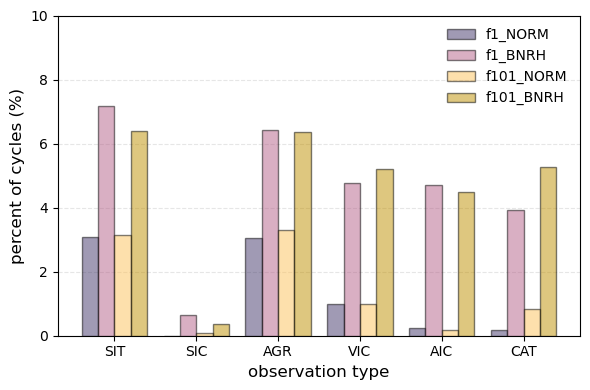

In [69]:
plt.figure(figsize=(6,4))
plt.grid(axis='y', color = '0.9', linestyle='dashed', zorder=0)
colors = ['#42376a','#b46088','#fcc25a','#bf9000']
# colors = ['rebeccapurple', 'mediumpurple', 'lightgreen', 'forestgreen']

n = np.shape(bars)[1]
w = .2
x = np.arange(0, np.shape(bars)[0]) 
names = ['SIT', 'SIC','AGR', 'VIC', 'AIC', 'CAT']#'SIT', 'SIC', 
filts = ['f1_NORM', 'f1_BNRH', 'f101_NORM', 'f101_BNRH']

for i in range(0, np.shape(bars)[1]):
    position = x + (w*(1-n)/2) + i*w
    plt.bar(position, bars[:,i], width = w, label = filts[i], color = colors[i], alpha = 0.5,edgecolor='black', zorder = 3)

plt.xticks(np.arange(0,np.shape(bars)[0]), labels = names)
plt.ylim([0,10])
plt.ylabel('percent of cycles (%)', fontsize=12)
plt.xlabel('observation type', fontsize=12)
plt.legend(fontsize=10, ncol=1, loc = 'upper right', frameon=False)
# plt.title('Percent of Cycles Violating SIC Bounds', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('figures/postprocessing_barplot.png', dpi=300, bbox_inches='tight')